## Plotting Profiler Data in Real-Time 

In this example we will learn how to plot data from Shallow Profilers in real-time. We will use data from the CTD on the Shallow Profiler at Axial Base. You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to continuously request JSON data
* how to extract the relevant data on the fly and plot profiles in real-time

In [1]:
import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4 as nc
from IPython import display

In this example we will build real-time requests for data from the Cabled Axial Base (RS03AXPS) - Shallow Profiler (SF03A) - CTD (2A-CTDPFA302) sensor. The ingredients being used to build the data_request_url can be found here: http://ooi.visualocean.net/instruments/view/RS03AXPS-SF03A-2A-CTDPFA302. To build an M2M request, you need the Reference Designator, Delivery Method and Data Stream Name. Note that streams containing science data products for a given instrument are designated as Science in the Type column.

![RS03AXPS-SF03A-2A-CTDPFA302](https://github.com/friedrichknuth/ooi_data_analysis/raw/master/qc_db_images/RS03AXPS-SF03A-2A-CTDPFA302.png)

In [2]:
subsite = 'RS03AXPS'
node = 'SF03A'
sensor = '2A-CTDPFA302'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

Login in at https://ooinet.oceanobservatories.org/ and obtain your username and token under your profile (top right corner).

In [3]:
username = ''
token = ''

base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

Optionally, you can handle authentication outside the notebook by setting up a .netrc file in your home directory and loading it with your bash profile. 

In [4]:
# import netrc
# netrc = netrc.netrc()
# remoteHostName = "ooinet.oceanobservatories.org"
# info = netrc.authenticators(remoteHostName)
# username = info[0]
# token = info[2]

The code will start by requesting the last 10 seconds of data and then make a new request every second by replacing the request url start time with the time stamp of the last data point received. No end time is specified, so everything available up until present will be returned, and the limit is set to 1000 data points for any given request. No sensor is sampling at > 100 Hz, so you are guaranteed to receive all available data in the response.

![RS03AXPS-SF03A-2A-CTDPFA302](https://github.com/friedrichknuth/ooi_data_analysis/raw/master/qc_db_images/realtime_pseudo_code.png)

In [5]:
# get the time stamp of the last 10 seconds of data
beginDT = (datetime.datetime.utcnow() - datetime.timedelta(seconds=10)).strftime("%Y-%m-%dT%H:%M:%S.000Z")

# build the url and request parameters
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'limit':100,   
}

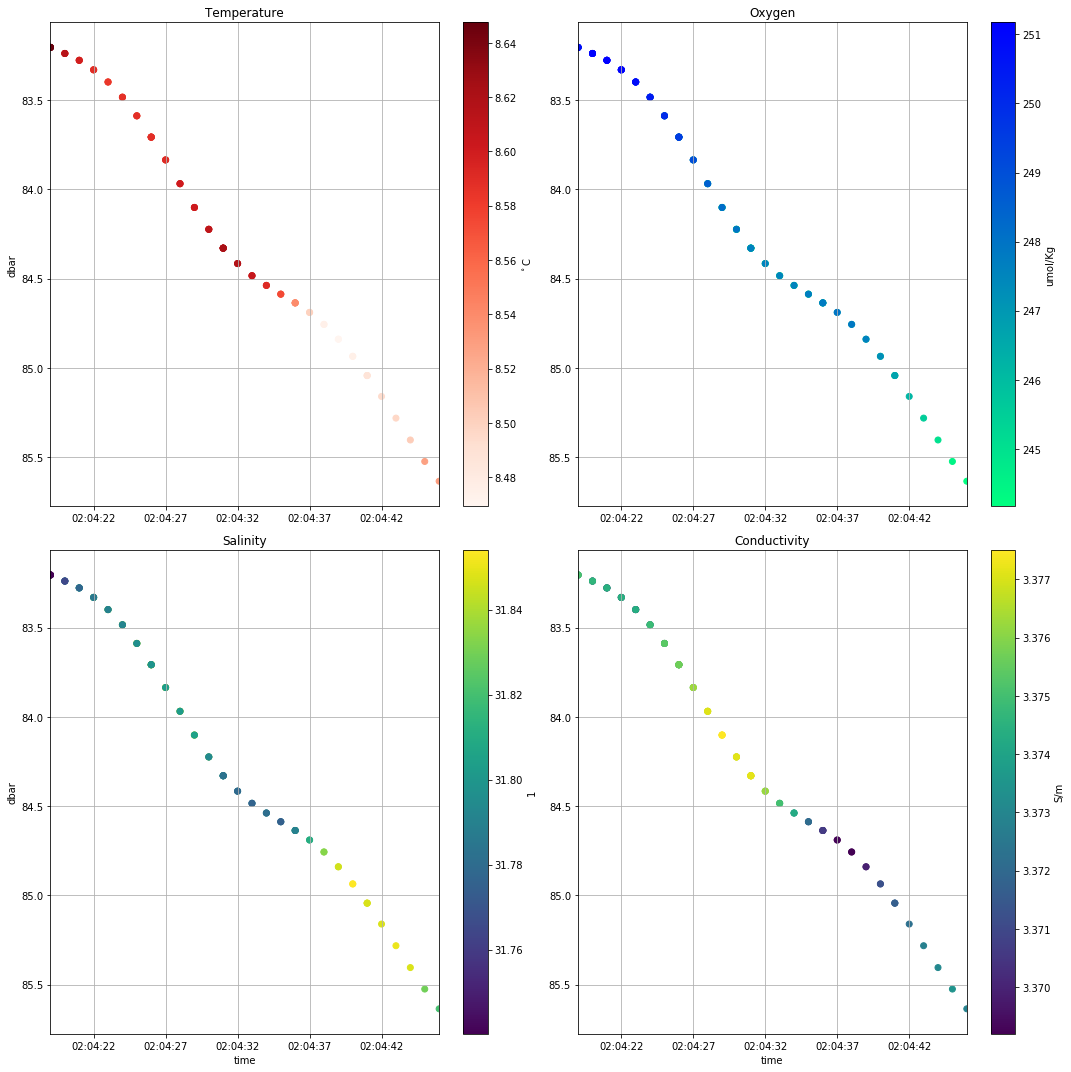

In [6]:
# set up your variable lists to extract from the json response
time_stamp = []
pressure = []
temperature = []
salinity = []
oxygen = []
conductivity = []

# set up the plot
fig = plt.figure(figsize=(15, 15))
spec = gridspec.GridSpec(ncols=2, nrows=2)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1], sharey=ax1)
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1], sharey=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

# invert the pressure axis so shallower is upwards 
# could also multiply all pressure values by -1 and treat dbar = depth
ax1.invert_yaxis()
ax3.invert_yaxis()

# enter request and plotting loop
# while True: # use for endless loop
for i in range(1000):
    
    # send request for data
    response = requests.get(data_request_url, params=params, auth=(username, token))
    data = response.json()
    
    # get last time stamp in response
    last_time = nc.num2date(data[-1]['time'],'seconds since 1900-01-01').strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    # check if new data has been received
    if params['beginDT'] == last_time:
        continue
        
    # if new data is reveived, extract and append values to list, then plot
    else:
        # extract variables
        for i in range(len(data)):
            time_stamp.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
            pressure.append(data[i]['seawater_pressure'])
            temperature.append(data[i]['seawater_temperature'])
            oxygen.append(data[i]['corrected_dissolved_oxygen'])
            salinity.append(data[i]['practical_salinity'])
            conductivity.append(data[i]['seawater_conductivity'])

        # remove colorbars for continuous replotting (there might be a better way to do this)
        try:
            cb1.remove()
            cb2.remove()
            cb3.remove()
            cb4.remove()
        except:
            pass

        # set x axis limit to extent of data
        ax1.set_xlim(time_stamp[0],time_stamp[-1])
        ax2.set_xlim(time_stamp[0],time_stamp[-1])
        ax3.set_xlim(time_stamp[0],time_stamp[-1])
        ax4.set_xlim(time_stamp[0],time_stamp[-1])

        # choose the colormaps. more colormaps at https://matplotlib.org/examples/color/colormaps_reference.html
        cmap1 = plt.get_cmap("Reds")
        cmap2 = plt.get_cmap("winter_r")
        # cmap3 = plt.get_cmap("copper")
        # cmap4 = plt.get_cmap("copper")

        # plot the data
        t = ax1.scatter(time_stamp, pressure, c=temperature, cmap=cmap1)
        o = ax2.scatter(time_stamp, pressure, c=oxygen, cmap=cmap2)
        s = ax3.scatter(time_stamp, pressure, c=salinity)
        c = ax4.scatter(time_stamp, pressure, c=conductivity)

        # assign a colorbar 
        cb1 = plt.colorbar(t,ax=ax1)
        cb2 = plt.colorbar(o,ax=ax2)
        cb3 = plt.colorbar(s,ax=ax3)
        cb4 = plt.colorbar(c,ax=ax4)

        # label colorbars
        cb1.set_label('$^\circ$C')
        cb2.set_label('umol/Kg')
        cb3.set_label('1')
        cb4.set_label('S/m')

        # label subplots
        ax1.set_title("Temperature")
        ax2.set_title("Oxygen")
        ax3.set_title("Salinity")
        ax4.set_title("Conductivity")

        ax1.set_ylabel('dbar')
        ax3.set_ylabel('dbar')

        ax3.set_xlabel('time')
        ax4.set_xlabel('time')

        # tighten layout and display plot
        spec.tight_layout(fig)

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    
    # reset beginDT for next request    
    params['beginDT'] = last_time
    
plt.close()